## Exploration_12_영화예측

1. 데이터준비
2. 데이터 전처리
3. Modeling
4. Model training
5. 회고

### 1. 데이터 준비

In [7]:
import datetime as dt
from pathlib import Path
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [8]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 2. 데이터 전처리
#### User 별 평가 수 확인

In [9]:
# user 별 사용 수 확인
user_session = data.groupby('UserId').size()

In [10]:
user_session

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [11]:
# max 값이 비정상적으로 높아 보인다
user_session.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [12]:
# session max 값 확인
data[data['UserId'] == user_session[user_session==2314].index[0]]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


* user_session 이 max 값에 해당하는 자료를 확인한 결과 동일한 UserId를 이용해 동일한 시간에 평가 된 항목들이 상당히 많다. 이는 정상적인 데이터로 보이지 않기 때문에 Time을 기준으로 duplicates 데이터를 삭제하기로 한다.

#### drop_duplicates

In [13]:
# Time 기준 duplicates 삭제
data = data.drop_duplicates(['Time'], keep='first')

In [14]:
# data 수 변화 : 1000209 -> 458455
data.shape

(458455, 4)

In [15]:
# user 별 사용 수 확인
user_session = data.groupby('UserId').size()
user_session

UserId
1        34
2        66
3        31
4         7
5        83
       ... 
6036    186
6037     56
6038     14
6039     46
6040    167
Length: 6040, dtype: int64

In [16]:
user_session.describe()

count    6040.000000
mean       75.903146
std        89.550714
min         2.000000
25%        20.000000
50%        41.000000
75%        94.000000
max       893.000000
dtype: float64

In [17]:
# Time 중복은 모두 드랍 됨
data[data['UserId'] == user_session[user_session==893].index[0]]

,UserId,ItemId,Rating,Time
171477,1088,260,5,974930951
171224,1088,912,5,974931043
171113,1088,589,4,974931244
172077,1088,1035,4,974931419
171897,1088,3512,4,974931577
...,...,...,...,...
171531,1088,2844,3,1045529893
171936,1088,2728,3,1045529943
171978,1088,3543,4,1045530142
171708,1088,2314,4,1045995723


* 같은 UserId가 사용 된 평가중에서 중복된 시간 실시 된 데이터들이 드랍된 것을 확인 할 수 있다.

In [18]:
length_count = user_session.groupby(user_session).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

2      0.000166
3      0.000828
4      0.003146
5      0.007616
6      0.014570
         ...   
617    0.998179
618    0.998344
634    0.998510
640    0.998675
648    0.998841
Length: 425, dtype: float64

#### 분포도 확인

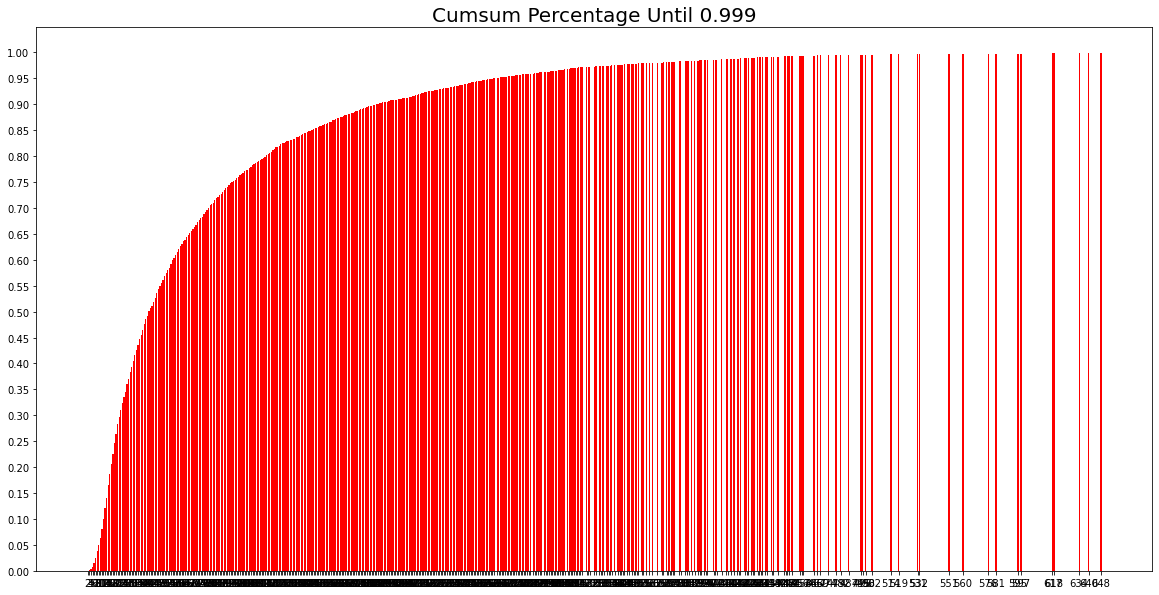

In [19]:
# 99.9% 까지의 분포 누적 합
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

* 99.9% 데이터에 대한 분포를 보면 뒤로 갈 수록 간격이 벌어진 데이터들이 보이는데 이들을 outlier에 가까운 값이라고 보면 될 듯 하다.

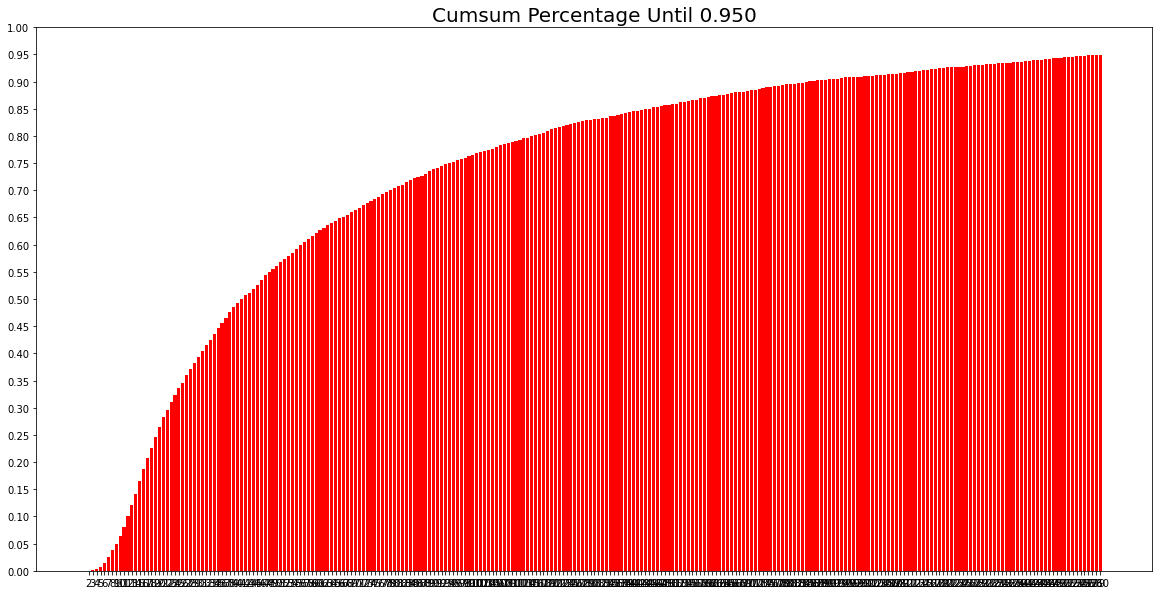

In [20]:
# 95.0% 까지의 분포 누적 합
import matplotlib.pyplot as plt

length_count = user_session.groupby(user_session).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.950]

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.950', size=20)
plt.show()

* 이를 95% 범위로 줄여보면 이 범위에 해당하는 데이터들은 밀집된 형태의 분포를 가진다는 것을 알 수 있다.

#### data cleasing

In [21]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [22]:
# UserId size : 1인 데이터 제거 
# least_click : 평가가 3회 이하 인 데이터 제거 (인기가 없다고 판단)
data = cleanse_recursive(data, shortest=1, least_click=3)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


* 추천이라는게 인기가 있거나 있을만한 것들, 그리고 믿을 만한 것들 위주로 이루어 지는 것이 옳다고 생각한다.
* 따라서 우선 평가가 1개 뿐인 userid 는 신뢰성 부분에서 부적합하다고 생각하여 삭제하고, 총 평가가 3개 이하인 경우 인기가 없다고 판단하여 삭제 하였다.
* 최종적으로 기존 458455 rows 에서 458131 rows 로 변경. 대략 300 rows 정도가 추가로 제거 됨.

#### Session ( UserId가 사용된 횟수 ) column 추가

In [50]:
tmp_data = data
tmp_data['Session'] = 0

for idx, val in enumerate(user_session):
    tmp_data.loc[tmp_data['UserId']==idx+1, 'Session'] = val

* 별도의 Series 형태로 가지고 있던 데이터를 기존의 data에 합쳤다.
* data.groupby('UserId').size() 값이 들어있다.

In [29]:
tmp_data.head()

,UserId,ItemId,Rating,Time,Session
31,1,3186,4,978300019,34
22,1,1270,5,978300055,34
24,1,2340,3,978300103,34
36,1,1836,5,978300172,34
3,1,3408,4,978300275,34


In [31]:
data = tmp_data
data.head()

,UserId,ItemId,Rating,Time,Session
31,1,3186,4,978300019,34
22,1,1270,5,978300055,34
24,1,2340,3,978300103,34
36,1,1836,5,978300172,34
3,1,3408,4,978300275,34


* data에 반영

#### Train, test set 분리

In [32]:
# data를 train, validation, test 의 3 세트로 분리
data = data.sort_values(by=['Time'])
tr, val, test = data[:-int(len(data)*(0.2))], data[-int(len(data)*(0.2)):-int(len(data)*(0.1))], data[-int(len(data)*(0.1)):]

* data를 train, validation, test의 3 set으로 나눈다.
* 비율은 적당히 tr : val : test = 8 : 1 : 1 로 설정하였다.

In [154]:
# data에 대한 전반적인 정보 확인
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [155]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 366505
	 Items: 3357
	 First Time : 956703932
	 Last Time : 976311712

* valid Set Stats Info
	 Events: 45813
	 Items: 3046
	 First Time : 976311716
	 Last Time : 983416929

* test Set Stats Info
	 Events: 45813
	 Items: 3164
	 First Time : 983416953
	 Last Time : 1046454590



In [153]:
val.shape

(45813, 5)

In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Session-Parallel Mini-Batch
#### SessionDataSet

In [35]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['Session'].nunique())  # indexing to Session

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['Session'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('Session').size().cumsum()
        return offsets

In [36]:
tr.head()

,UserId,ItemId,Rating,Time,Session,item_idx
1000138,6040,858,4,956703932,167,0
999873,6040,593,5,956703954,167,1
1000007,6040,1961,4,956703977,167,2
999868,6040,573,4,956704056,167,3
1000155,6040,1734,2,956704081,167,4


In [37]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Session,item_idx
1000138,6040,858,4,956703932,167,0
999873,6040,593,5,956703954,167,1
1000007,6040,1961,4,956703977,167,2
999868,6040,573,4,956704056,167,3
1000155,6040,1734,2,956704081,167,4
999884,6040,912,5,956704191,167,5
1000186,6040,527,5,956704219,167,6
999953,6040,649,5,956704257,167,7
1000108,6040,3289,5,956704305,167,8
1000083,6040,759,5,956704448,167,9


In [38]:
tr_dataset.click_offsets

array([     0,      2,     14,     70,    190,    425,    855,   1431,
         1974,   2846,   3860,   5212,   6661,   8159,  10287,  12257,
        14200,  16063,  18149,  20225,  22348,  23948,  25740,  27466,
        29179,  30572,  32792,  34352,  36273,  37932,  39645,  41559,
        43273,  45260,  47299,  48984,  50771,  53163,  54901,  56417,
        58086,  59583,  60682,  62445,  64300,  66493,  68630,  70061,
        71566,  73279,  75185,  76928,  78557,  79903,  82260,  84205,
        85676,  87407,  89165,  91244,  92988,  94218,  95943,  96784,
        98273,  99896, 100894, 102194, 103895, 105187, 106589, 108651,
       110325, 111289, 112584, 114482, 116284, 118091, 119366, 121523,
       122747, 123906, 125690, 127327, 128769, 129843, 131063, 132771,
       134799, 136667, 137921, 139536, 141062, 142513, 143368, 144454,
       145951, 147145, 148850, 149591, 151414, 152656, 153934, 154580,
       155908, 157338, 158985, 159973, 161310, 162064, 163463, 164844,
      

In [39]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

#### SessionDataLoader

In [40]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [41]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Session,item_idx
1000138,6040,858,4,956703932,167,0
999873,6040,593,5,956703954,167,1
1000007,6040,1961,4,956703977,167,2
999868,6040,573,4,956704056,167,3
1000155,6040,1734,2,956704081,167,4
999884,6040,912,5,956704191,167,5
1000186,6040,527,5,956704219,167,6
999953,6040,649,5,956704257,167,7
1000108,6040,3289,5,956704305,167,8
1000083,6040,759,5,956704448,167,9


In [42]:
iter_ex = iter(tr_data_loader)

In [43]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  2 14 70]
Label Item Idx are :       [ 1  3 15 71]
Previous Masked Input Idx are []


### 3. Modeling

In [44]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [46]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [47]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['Session'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [48]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3357)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  511350    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3357)              171207    
Total params: 682,557
Trainable params: 682,557
Non-trainable params: 0
_________________________________________________________________


### 4. Model Training

In [49]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['Session'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['Session'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
train_model(model, args)

#### Test model 결과 확인

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

### 5. 회고

* 결론적으로 이번 노드의 코드 진행 방식에 대해 데이터 전처리 이후의 상당부분 이해를 하지 못했다.
* 지금까지의 다른 노드의 경우에는 두세번 반복하면 코드의 흐름을 따라가기에 충분할 정도로 이해되었고, 따라서 직접 작성하고 수정 해 가면서 진행하는 것이 가능했는데 이번에는 아무리 여러번 보려고 해도 그 흐름이 전혀 잡히질 않았다. 긴 시간을 투자해서 한줄씩 코딩해가며 확인하면 이해가 될 수도 있겠지만, 당장 현실적으로 다른 과제들을 미뤄두고 여기에만 시간을 투자하기에는 힘들다고 생각되어 이쯤에서 마무리 하고 나중에 시간적인 제약이 없을 때 다시 보기로 결정했다.
* 따라서 결과에 대해서는 회고를 작성할 수 없지만, 데이터와 코드를 보면서 느낀점, 생각한 점에 대해 적어보겠다.
* 일단 노드의 과제는 유저별로 관람한 영화에대한 정보가 데이터로 존재하는 상황에서, 이 유저에게 성향에 맞춘 적절한 다음 영화를 추천하는 것이 목표이었다.
* 개인적으로 추천이 이뤄지는 방식은 상당히 간단하다고 생각된다. 먼저 각 영화들 마다 고유 id가 itemId의 형태로 존재하는데, 각 유저들별로 가지고 있는 itemId 값들을 list로 만들어 저장해 둔다.
* 그리고 list의 값들을 sorting 한 뒤에 model을 이용해 어떤순서로 itemId가 배치 되어있는지 train set을 이용해 학습 시킨다.
* 그 다음 test 값이 들어왔을 때 해당 test값의 itemId를 확인하고, 다음에 올 itemId를 학습결과를 토대로 추천하는 것으로 마무리 된다.
* 예를 들자면 train set 이 [1, 2, 3], [2, 3, 4], [1, 3, 5] 라고 학습이 된 상태에서 test 값으로 2가 들어온다면 3을 추천하고 3이 들어온다면 4 or 5를 추천하는 식으로 진행될 것이다.
* 추가적으로 rating를 이용해보자면, itemId와 rating 정보를 함께 학습을 시킨 뒤 추천하고자 하는 영화를 3개 정도 선별한 뒤에 rating 값을 확인하여 rating이 1, 2 라면 그 다음 영화를 추천하고 선별한 세 영화 모두 rating이 낮다면 다시 선별하는 식으로 진행 할 수 있을 것 같다.
* 그리고 이 방식을 사용하기 위해서는 총 평가 인원 수가 상당히 낮은 영화라던가, 한 편만 평가를 한 유저등에 대한 정보는 모델 학습에 도움이 되지않을 것이기 때문에 모두 제거하고 하나의 아이디로 동시간에 여러개의 평가가 진행 된 데이터들도 신뢰할 수 없다고 생각되기 때문에 역시 제거 해줄 필요가 있다.
* 결론적으로 이런 과제에서 우리가 원하는 수준의 추천 정확도를 얻기 위해서는 개인적으로는 모델 자체의 성능개선(parameter 조절 등) 보다 데이터 전처리와 데이터의 양이 중요하다고 생각된다.
* 현재 본인의 실력으로는 이런 과제들에 적용해볼 수 있는 다양한 생각들이 있어도 이 모두를 실제 코드로 구현하는게 상당히 쉽지가 않은 것이 사실이다. 앞으로도 많은 노력이 필요할 것이라 생각된다.